# Тестовое задание

In [95]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import string

In [96]:
count_vect = CountVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
tfidf_vect = TfidfVectorizer(max_df = 0.9, min_df = 10, ngram_range=(1, 3))
porter_stemmer = nltk.stem.PorterStemmer()
tok = count_vect.build_tokenizer()
# tok = tfidf_vect.build_tokenizer()
# tok = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize
clf = LogisticRegression(solver='liblinear', class_weight = {0:4, 1:1}, penalty='l2')

## Cкачиваем файл с данными

In [97]:
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
#или
#!wget https://drive.google.com/open?id=1DwwTyIn5zW7KTxp4bONHtKNa6DlT9PUj

## Если необходимо, преобразуем JSON к CSV

In [98]:
# df = pd.read_json ('Electronics_5.json', lines=True )
# df.to_csv ('Electronics_5.csv', index = None)

# Предобработка

In [99]:
dat = pd.read_csv("Electronics_5.csv", engine= 'python', error_bad_lines=False)[["asin","reviewText", "overall"]]

## Добавляем бинрную оценку

In [100]:
dat["bin"] = dat.overall > 3

## Отрежем кусок даты

In [101]:
dat_t, dat = dat, dat[:16000]

In [102]:
train_dat, privat_dat, train_ans, privat_ans = train_test_split(
    dat.reviewText, dat.bin, test_size=0.15)

In [103]:
train_dat, test_dat, train_ans, test_ans = train_test_split(
    train_dat, train_ans, test_size=0.2)

## Натравим на необработанные данные

In [104]:
count_vect.fit(dat.reviewText.apply(lambda x: np.str_(x)))
tfidf_vect.fit(dat.reviewText.apply(lambda x: np.str_(x)))
count_train_mtrx_dft = count_vect.transform(train_dat.apply(lambda x: np.str_(x)))
tfidf_train_mtrx_dft = tfidf_vect.transform(train_dat.apply(lambda x: np.str_(x)))
count_test_mtrx_dft = count_vect.transform(test_dat.apply(lambda x: np.str_(x)))
tfidf_test_mtrx_dft = tfidf_vect.transform(test_dat.apply(lambda x: np.str_(x)))

## Приводим к базовой форме

In [105]:
train_dat_tr = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), train_dat.apply(lambda x: np.str_(x)))))
test_dat_tr = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), test_dat.apply(lambda x: np.str_(x)))))
privat_dat_tr = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), privat_dat.apply(lambda x: np.str_(x)))))
dat["words"] = list(map(lambda elem: (" ").join(map(lambda s: (porter_stemmer.stem(s)), elem)).lower().translate(str.maketrans('', '', string.punctuation)), map(lambda wrds: tok(wrds), dat.reviewText.apply(lambda x: np.str_(x)))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Натравим на обработанные данные

In [106]:
# count_vect.fit(dat.words)
# tfidf_vect.fit(dat.words)
count_train_mtrx = count_vect.transform(train_dat_tr)
tfidf_train_mtrx = tfidf_vect.transform(train_dat_tr)
count_test_mtrx = count_vect.transform(test_dat_tr)
tfidf_test_mtrx = tfidf_vect.transform(test_dat_tr)

## Проверим, что получилось

In [107]:
dat

,asin,reviewText,overall,bin,words
0,0528881469,We got this GPS for my husband who is an (OTR)...,5,True,we got thi gp for my husband who is an otr ove...
1,0528881469,"I'm a professional OTR truck driver, and I bou...",1,False,profession otr truck driver and bought tnd 700...
2,0528881469,"Well, what can I say. I've had this unit in m...",3,False,well what can say ve had thi unit in my truck ...
3,0528881469,"Not going to write a long review, even thought...",2,False,not go to write long review even thought thi u...
4,0528881469,I've had mine for a year and here's what we go...,1,False,ve had mine for year and here what we got it t...
...,...,...,...,...,...
15995,B00004ZCJE,I could not ask more of the Tiffen 58mm UV Pro...,5,True,could not ask more of the tiffen 58mm uv prote...
15996,B00004ZCJE,I ordered 2 Tiffen 52 mm UV filters for the 2 ...,4,True,order tiffen 52 mm uv filter for the lens that...
15997,B00004ZCJE,It protects the lens. But I still have glare f...,4,True,it protect the len but still have glare from l...
15998,B00004ZCJE,"buena calidad, resistente, producto bien hecho...",5,True,buena calidad resistent producto bien hecho la...


# Обучим модели и посмотрим их точность

## Обработанные с оптимальными параметрами

In [108]:
param_grid = {
    'C': np.arange(0.1, 3, 0.1),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None, {0:4, 1:1}]
}
search = GridSearchCV(clf, param_grid, cv=5)
search.fit(count_train_mtrx, train_ans)
print(search.best_params_)

{'C': 0.1, 'class_weight': None, 'penalty': 'l2'}


In [109]:
accuracy_score(test_ans, search.best_estimator_.predict(count_test_mtrx))

0.8636029411764706

In [110]:
param_grid = {
    'C': np.arange(0.1, 3, 0.1),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None, {0:4, 1:1}]
}
search = GridSearchCV(clf, param_grid, cv=5)
search.fit(tfidf_train_mtrx,  train_ans)
print(search.best_params_)

{'C': 2.5000000000000004, 'class_weight': None, 'penalty': 'l1'}


In [111]:
accuracy_score(test_ans, search.best_estimator_.predict(tfidf_test_mtrx))

0.8639705882352942

## Дефолтные с оптимальными параметрами

In [112]:
param_grid = {
    'C': np.arange(0.1, 3, 0.1),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None, {0:4, 1:1}]
}
search = GridSearchCV(clf, param_grid, cv=5)
search.fit(count_train_mtrx_dft, train_ans)
print(search.best_params_)

{'C': 0.2, 'class_weight': None, 'penalty': 'l2'}


In [113]:
print(accuracy_score(test_ans, search.best_estimator_.predict(count_test_mtrx_dft)))
print(classification_report(test_ans, search.best_estimator_.predict(count_test_mtrx_dft)))

0.875
              precision    recall  f1-score   support

       False       0.73      0.50      0.59       495
        True       0.90      0.96      0.93      2225

    accuracy                           0.88      2720
   macro avg       0.81      0.73      0.76      2720
weighted avg       0.87      0.88      0.87      2720



In [114]:
param_grid = {
    'C': np.arange(0.1, 3, 0.1),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None, {0:4, 1:1}]
}
search = GridSearchCV(clf, param_grid, cv=5)
search.fit(tfidf_train_mtrx_dft, train_ans)
print(search.best_params_)

{'C': 2.9000000000000004, 'class_weight': {0: 4, 1: 1}, 'penalty': 'l2'}


In [115]:
print(accuracy_score(test_ans, search.best_estimator_.predict(tfidf_test_mtrx_dft)))
print(classification_report(test_ans, search.best_estimator_.predict(tfidf_test_mtrx_dft)))


0.8768382352941176
              precision    recall  f1-score   support

       False       0.66      0.66      0.66       495
        True       0.93      0.92      0.92      2225

    accuracy                           0.88      2720
   macro avg       0.79      0.79      0.79      2720
weighted avg       0.88      0.88      0.88      2720



# Лучший результат у tfidf на необработанных данных

In [116]:
clf.fit(tfidf_train_mtrx_dft, train_ans)
pred = search.best_estimator_.predict(tfidf_vect.transform(privat_dat.apply(lambda x: np.str_(x))))
print(accuracy_score(pred, privat_ans))
print(classification_report(pred, privat_ans))

0.86625
              precision    recall  f1-score   support

       False       0.60      0.61      0.61       407
        True       0.92      0.92      0.92      1993

    accuracy                           0.87      2400
   macro avg       0.76      0.76      0.76      2400
weighted avg       0.87      0.87      0.87      2400



## Проверим баланс классов

In [117]:
print("All :\n1 - ", sum(dat.bin), "\n0 - ", len(dat.bin) - sum(dat.bin), "\n", round(100*sum(dat.bin)/len(dat.bin), 2)) 
print("\nTrain :\n1 - ", sum(train_ans), "\n0 - ", len(train_ans) - sum(train_ans), "\n", round(100*sum(train_ans)/len(train_ans), 2)) 
print("\nTest :\n1 - ", sum(test_ans), "\n0 - ", len(test_ans) - sum(test_ans), "\n", round(100*sum(test_ans)/len(test_ans), 2) )
print("\nPrivat_ans :\n1 - ", sum(privat_ans), "\n0 - ", len(privat_ans) - sum(privat_ans), "\n", round(100*sum(privat_ans)/len(privat_ans), 2) ) 

All :
1 -  13194 
0 -  2806 
 82.46

Train :
1 -  8979 
0 -  1901 
 82.53

Test :
1 -  2225 
0 -  495 
 81.8

Privat_ans :
1 -  1990 
0 -  410 
 82.92


# Возьмем новый набор данных

In [118]:
dat2 = pd.read_json("Tools_and_Home_Improvement_5.json", lines = True)[["reviewText", "overall"]]

In [119]:
dat2["bin"] = dat2.overall > 3

## Истинное значение

In [120]:
rat = (len(dat2.bin)-sum(dat2.bin)) / sum(dat2.bin)
print("Соотношение false/true:",len(dat2.bin)-sum(dat2.bin), " / ", sum(dat2.bin))
ground_t = accuracy_score(dat2.bin, search.best_estimator_.predict(tfidf_vect.transform(dat2.reviewText)))
print(ground_t)
print(classification_report(dat2.bin, search.best_estimator_.predict(tfidf_vect.transform(dat2.reviewText))))

Соотношение false/true: 20874  /  113602
0.8479803087539785
              precision    recall  f1-score   support

       False       0.51      0.64      0.57     20874
        True       0.93      0.89      0.91    113602

    accuracy                           0.85    134476
   macro avg       0.72      0.76      0.74    134476
weighted avg       0.87      0.85      0.85    134476



## Случайный выбор

In [121]:
df_rand_ch = dat2.sample(2000)
print("Соотношение false/true:",len(df_rand_ch.bin)-sum(df_rand_ch.bin), " / ", sum(df_rand_ch.bin))
print(accuracy_score(df_rand_ch.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rand_ch.reviewText))))
print(classification_report(df_rand_ch.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rand_ch.reviewText))))

Соотношение false/true: 297  /  1703
0.856
              precision    recall  f1-score   support

       False       0.51      0.65      0.57       297
        True       0.94      0.89      0.91      1703

    accuracy                           0.86      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.87      0.86      0.86      2000



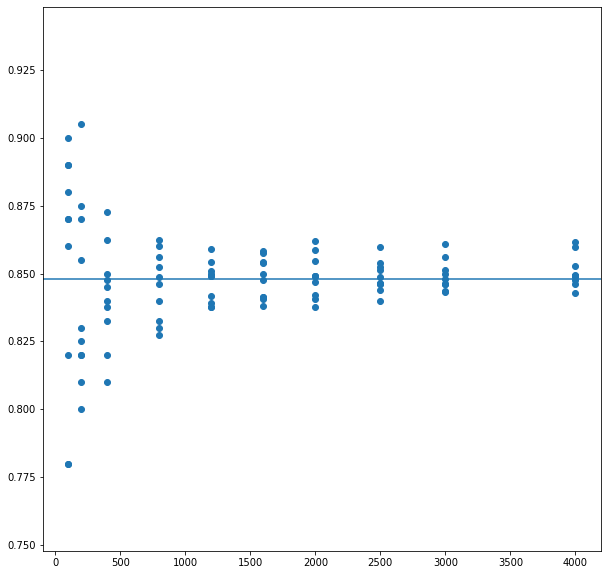

In [122]:
acc_list = []
size_list = []
for sample_size in [100, 200, 400, 800, 1200, 1600, 2000, 2500, 3000, 4000]:
  for seed in range(10):
    np.random.seed(seed)
    df_rand_ch = dat2.sample(sample_size)
    acc_list.append(accuracy_score(df_rand_ch.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rand_ch.reviewText))))
    size_list.append(sample_size)
plt.figure(figsize=(10, 10))
plt.ylim([ground_t - 0.1, ground_t + 0.1,])
plt.scatter(size_list, acc_list)
plt.axhline(y = ground_t)
plt.show()
    

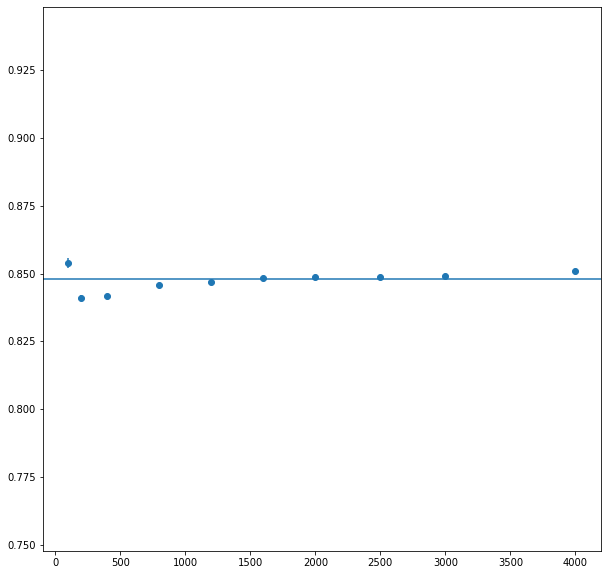

In [123]:
mean_list = []
var_list = []
sample_size_list = [100, 200, 400, 800, 1200, 1600, 2000, 2500, 3000, 4000]
for sample_size in sample_size_list:
  acc_list = []
  for seed in range(10):
    np.random.seed(seed)
    df_rand_ch = dat2.sample(sample_size)
    acc_list.append(accuracy_score(df_rand_ch.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rand_ch.reviewText))))
  mean_list.append(np.mean(acc_list))
  var_list.append(np.var(acc_list))  
plt.figure(figsize=(10, 10))
plt.ylim([ground_t - 0.1, ground_t + 0.1,])
plt.errorbar(sample_size_list, mean_list, yerr=var_list, fmt='o', )
plt.axhline(y = ground_t)
plt.show()
    

## Случайный равномерный выбор

In [124]:
df_rc_eq = pd.concat([dat2.loc[dat2['bin']].sample(2000//2), dat2.loc[dat2['bin'] != True].sample(2000//2)], ignore_index=True)
print("Соотношение false/true:",len(df_rc_eq.bin)-sum(df_rc_eq.bin), " / ", sum(df_rc_eq.bin))
print(accuracy_score(df_rc_eq.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rc_eq.reviewText))))
print(classification_report(df_rc_eq.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rc_eq.reviewText))))

Соотношение false/true: 1000  /  1000
0.7655
              precision    recall  f1-score   support

       False       0.85      0.64      0.73      1000
        True       0.71      0.89      0.79      1000

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.76      2000
weighted avg       0.78      0.77      0.76      2000



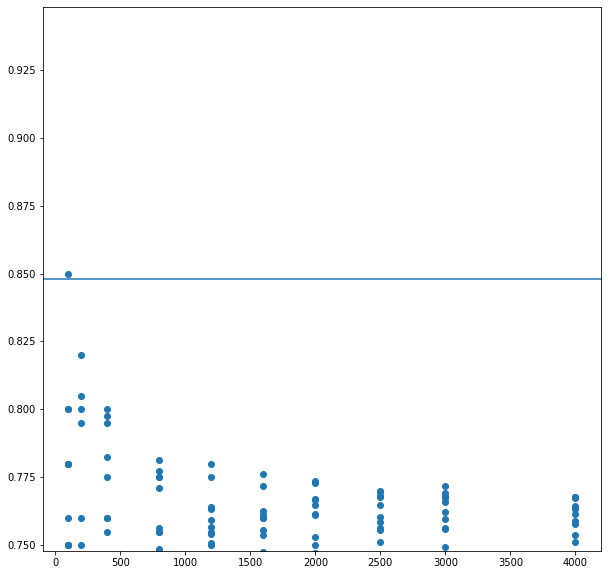

In [125]:
acc_list = []
size_list = []
for sample_size in [100, 200, 400, 800, 1200, 1600, 2000, 2500, 3000, 4000]:
  for seed in range(10):
    np.random.seed(seed)
    df_rc_eq = pd.concat([dat2.loc[dat2['bin']].sample(sample_size//2), dat2.loc[dat2['bin'] != True].sample(sample_size//2)], ignore_index=True)
    acc_list.append(accuracy_score(df_rc_eq.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rc_eq.reviewText))))
    size_list.append(sample_size)
plt.figure(figsize=(10, 10))
plt.ylim([ground_t - 0.1, ground_t + 0.1,])
plt.scatter(size_list, acc_list)
plt.axhline(y = ground_t)
plt.show()

## Случайный выбор с сохраненем баланса классов

In [126]:
df_rc_2 = pd.concat([dat2.loc[dat2['bin']].sample(round(2000*(1/(rat+1)))), dat2.loc[dat2['bin'] != True].sample(round(2000*rat/(rat+1)))], ignore_index=True)
print("Соотношение false/true:",len(df_rc_2.bin)-sum(df_rc_2.bin), " / ", sum(df_rc_2.bin))
print(accuracy_score(df_rc_2.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rc_2.reviewText))))
print(classification_report(df_rc_2.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rc_2.reviewText))))

Соотношение false/true: 310  /  1690
0.8495
              precision    recall  f1-score   support

       False       0.51      0.64      0.57       310
        True       0.93      0.89      0.91      1690

    accuracy                           0.85      2000
   macro avg       0.72      0.76      0.74      2000
weighted avg       0.87      0.85      0.86      2000



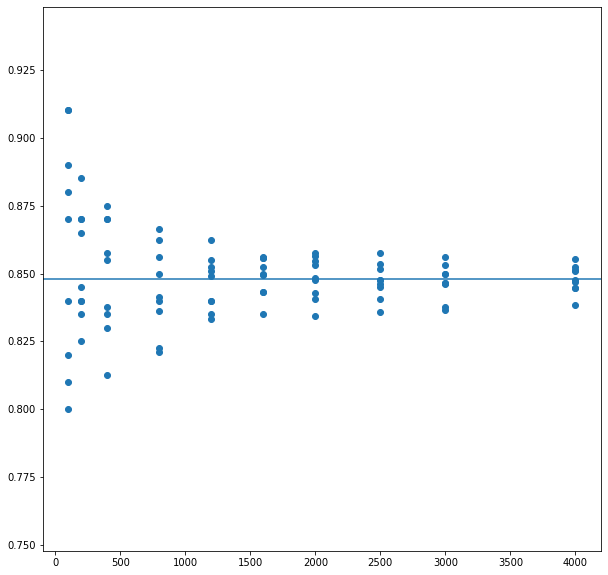

In [127]:
acc_list = []
size_list = []
for sample_size in [100, 200, 400, 800, 1200, 1600, 2000, 2500, 3000, 4000]:
  for seed in range(1, 10):
    np.random.seed(seed)
    df_rc_2 = pd.concat([dat2.loc[dat2['bin']].sample(round(sample_size*(1/(rat+1)))), dat2.loc[dat2['bin'] != True].sample(round(sample_size*rat/(rat+1)))], ignore_index=True)
    acc_list.append(accuracy_score(df_rc_2.bin, search.best_estimator_.predict(tfidf_vect.transform(df_rc_2.reviewText))))
    size_list.append(sample_size)
plt.figure(figsize=(10, 10))
plt.ylim([ground_t - 0.1, ground_t + 0.1,])
plt.scatter(size_list, acc_list)
plt.axhline(y = ground_t)
plt.show()

## По уверености классификатора

In [128]:
prob = search.best_estimator_.predict_proba(tfidf_vect.transform(dat2.reviewText))
prob = [x[0] for x in prob]

In [129]:
dat2["chance"] = prob

### Уверенность, что оценка <= 3

In [130]:
dat2 = dat2.sort_values(by = "chance")

In [131]:
dat2

,reviewText,overall,bin,chance
27435,GREAT.. ........... .......... ............ .....,5,True,0.000017
52596,great sharpener,5,True,0.000017
50418,GREAT,5,True,0.000017
43376,Great thermostat,4,True,0.000017
51595,Great hammer.,5,True,0.000017
...,...,...,...,...
98628,"At first, we were very pleased with the STI-34...",1,False,0.997914
52390,Does not work as easy as advertized. Does not...,3,False,0.998576
31175,This seemed OK when I first got it. But it sto...,1,False,0.998668
77560,"size & brightness is good, but the motion acti...",2,False,0.998968


In [132]:
class_conf_dat = dat2.iloc[::len(dat2.bin)//2000]
class_conf_dat

,reviewText,overall,bin,chance
27435,GREAT.. ........... .......... ............ .....,5,True,0.000017
23336,This is a great inexspensive regulator. We pur...,5,True,0.001529
121284,This is an excellent Fossett for the price. Lo...,5,True,0.002155
12344,Works well. Very happy with it. Does what I ne...,5,True,0.002775
75424,This is great glue. Very nice bottle/dispenser...,5,True,0.003208
...,...,...,...,...
75403,"After a few hours of use with this sander, it ...",2,False,0.979569
27692,These do not work. I have used a lower rated ...,1,False,0.983213
95892,I guess I didn't read the description well eno...,4,True,0.986661
125678,"I ordered three of these, and one's motion sen...",1,False,0.990735


In [133]:
print("Соотношение false/true:",len(class_conf_dat.bin)-sum(class_conf_dat.bin), " / ", sum(class_conf_dat.bin))
print("Всего " , (len(class_conf_dat.bin)))

Соотношение false/true: 313  /  1695
Всего  2008


In [134]:
print(accuracy_score(class_conf_dat.bin, search.best_estimator_.predict(tfidf_vect.transform(class_conf_dat.reviewText))))
print(classification_report(class_conf_dat.bin, search.best_estimator_.predict(tfidf_vect.transform(class_conf_dat.reviewText))))

0.848605577689243
              precision    recall  f1-score   support

       False       0.51      0.64      0.57       313
        True       0.93      0.89      0.91      1695

    accuracy                           0.85      2008
   macro avg       0.72      0.76      0.74      2008
weighted avg       0.87      0.85      0.86      2008



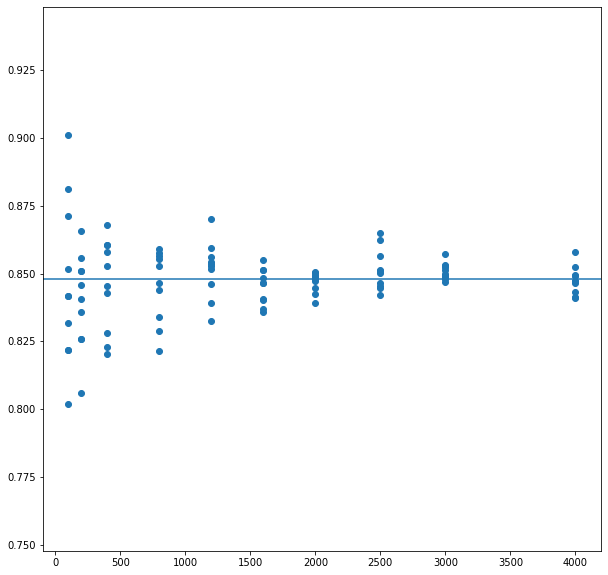

In [135]:
acc_list = []
size_list = []
for sample_size in [100, 200, 400, 800, 1200, 1600, 2000, 2500, 3000, 4000]:
  for step in range(10):
    class_conf_dat = dat2.iloc[step::len(dat2.bin)//sample_size]
    acc_list.append(accuracy_score(class_conf_dat.bin, search.best_estimator_.predict(tfidf_vect.transform(class_conf_dat.reviewText))))
    size_list.append(sample_size)
plt.figure(figsize=(10, 10))
plt.ylim([ground_t - 0.1, ground_t + 0.1,])
plt.scatter(size_list, acc_list)
plt.axhline(y = ground_t)
plt.show()